In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [2]:
_clear = ['bingroup']

def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            if hasattr(trace, prop):
                trace.update({prop: None})

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

def to_plotly_text(text):
    return text.strip().replace('\n', '<br>')

=(ch:mult_inference)
# Inference for Multiple Linear Regression 

In linear regression, we fit a model of the following form:

$$
\begin{aligned}
f_\boldsymbol\theta (\textbf{x})
  &= \boldsymbol\theta \cdot \textbf{x} \\
  &= \theta_0 + \theta_1 x_1
    + \ldots + \theta_p x_p
\end{aligned}
$$

This model says that our prediction $f_\boldsymbol\theta (\textbf{x})$
depends linearly on each feature $x_i$.
And after fitting on our sample, we find $ \hat{\boldsymbol \theta} $, the
model parameters that minimize our sample error.

Now, we'd like to generalize the model from the sample
to the population.
The key idea is to treat our data themselves as random draws from the
population.
Then, we can use bootstrap resampling to simulate drawing multiple samples.
We'll fit the model on each resample, make confidence intervals for 
the model parameters, and use the confidence intervals to make inferences
about the population.
Let's see this process through an example.

## The Data

Otis Dudley Duncan was a quantitative sociologist interested in measuring the prestige levels of different occupations. There were only 90 occupations that were rated for their prestige level in the 1947 National Opinion Research Center (NORC) survey. Duncan wanted to “fill in” prestige scores for unrated occupations by using income and education data about each occupation recorded by the 1950 census. When joining the NORC data with the 1950 census data, only 45 occupations could be matched. Ultimately, Duncan's goal was to create a model to explain prestige using different characteristics; using this model, one can predict the prestige of other occupations not recorded in the NORC survey.

The Duncan dataset is a random sample of that contains information on the prestige and other characteristics of 45 U. S. occupations in 1950. 
The variables are:

`occupation` represents the type of occupation/title.

`income` represents the percentage of occupational incumbents who earned incomes in excess of $3,500.

`education` represents the percentage of incumbents in the occupation in the 1950 U.S. Census who were high school graduates.

`prestige` represents the percentage of respondents in a survey who rated an occupation as “good” or “excellent” in prestige.






In [5]:
duncan = pd.read_csv('data/duncan.csv').loc[:, ["occupation", "income", "education", "prestige"]]
duncan

,occupation,income,education,prestige
0,accountant,62,86,82
1,pilot,72,76,83
2,architect,75,92,90
...,...,...,...,...
42,janitor,7,20,8
43,policeman,34,47,41
44,waiter,8,32,10


It's a good idea to explore the data through visualization in order to gain an understanding of the relationships between our variables.
To see if we can use income and education to predict prestige, we'll
create scatter plots that show the relation between these variables and
prestige.

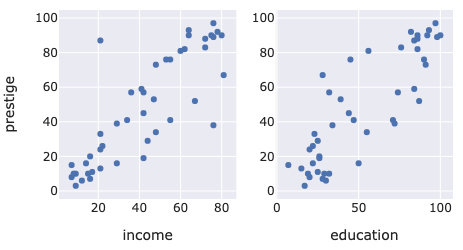

In [15]:
f1 = px.scatter(duncan, x='income', y='prestige')
f2 = px.scatter(duncan, x='education', y='prestige')

fig = left_right(f1, f2)
fig.update_xaxes(title='income', row=1, col=1)
fig.update_yaxes(title='prestige', row=1, col=1)
fig.update_xaxes(title='education', row=1, col=2)

From the plots above, we see that both education and income are positively correlated with prestige; hence, both of these variables might be useful in helping explain prestige. Let's fit a linear model using these explanatory variables to explain prestige.

## Fitting the model 

We will fit the following model, that explains the prestige of an occupation as a linear function of income and education:

$$
\begin{aligned}
\texttt{prestige}_i
= \theta_0^* 
+ \theta_\texttt{income}^*\cdot\texttt{income}_i
+ \theta_\texttt{education}^*\cdot\texttt{education}_i
+ \varepsilon_i
\end{aligned}
$$

In order to fit this model, we will define the design matrix (X) and our response variable (y):

In [16]:
X = duncan.loc[:, ["income", "education"]]
X.head()

,income,education
0,62,86
1,72,76
2,75,92
3,55,90
4,64,86


In [17]:
y = duncan.loc[:, "prestige"]
y.head()

0    82
1    83
2    90
3    76
4    90
Name: prestige, dtype: int64

Below, we fit our linear model and print all the $\widehat \theta$ coefficients of the model (from the equation above) after the model has been fit to the data. Note that these are our sample coefficients.

In [23]:
import sklearn.linear_model as lm

model = lm.LinearRegression()
model.fit(X, y)

intercept = model.intercept_
income, education = model.coef_

print(f"""
intercept:    {intercept:.2f}
income:       {income:.2f}
education:    {education:.2f}
""")


intercept:    -6.06
income:       0.60
education:    0.55



The coefficients above give us an estimate of the true coefficients. But had our sample data been different, we would have fit our model to different data, causing these coefficients to be different. We would like to explore what our coefficients might have been using bootstrapping methods.

In our bootstrapping methods and analysis, we will focus on the coefficient of education. We would like to explore the partial relationship between prestige and education holding income constant (rather than the marginal relationship between prestige and education ignoring income). The partial regression coefficient $\widehat\theta_\texttt{education}$ illustrates the partial relationship between prestige and education within our data. 

## Bootstrapping the Observations 

In this method, we consider the pairs $(X_i, y_i)$ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
\begin{aligned}
(X_i^*, y_i^*) 
= (X_I, y_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
\end{aligned}
$$

In other words, we sample n observations with replacement from our data points; this is our bootstrap sample. Then we will fit a new linear regression model to this sampled data and record the education coefficient $\tilde\theta_\texttt{education}$; this coefficient is our bootstrap statistic.

In [24]:
def simple_resample(n): 
    return np.random.randint(low=0, high=n, size=n)

def bootstrap(boot_pop, statistic, resample=simple_resample, replicates=10000):
    n = len(boot_pop)
    resample_estimates = [statistic(boot_pop[resample(n)])
                          for _ in range(replicates)]
    return np.array(resample_estimates)

In [25]:
def educ_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    
    linear_model = lm.LinearRegression()
    model = linear_model.fit(X, y)
    theta_educ = model.coef_[1]

    return theta_educ

data_array = duncan.loc[:, ["prestige", "income", "education"]].values

theta_hat_sampling = bootstrap(data_array, educ_coeff)

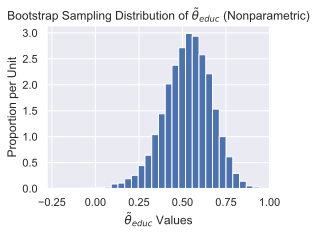

In [45]:
plt.figure(figsize = (4, 3))
plt.hist(theta_hat_sampling, bins=30, density=True)
plt.xlabel("$\\tilde{\\theta}_{educ}$ Values")
plt.ylabel("Proportion per Unit")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\theta}_{educ}$ (Nonparametric)");
plt.show()

Notice how the sampling distribution above is slightly skewed to the left. 

### Estimating the True Coefficients

Although we cannot directly measure $\theta^*_\texttt{education}$ we can use a bootstrap confidence interval to account for variability in the sample regression coefficient $\widehat\theta_{\texttt{education}}$. Below, We construct an approximate 95% confidence interval for the true coefficient $\theta^*_\texttt{education}$, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 10,000 bootstrapped coefficients.

In [46]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(0.2349176380021313, 0.7795582405415913)

From the confidence interval above, we estimate that the true coefficient lies between 0.236 and 0.775.

## Confidence Interval Using Normal Theory

We can also create confidence intervals based on normal theory. Since the $\widehat \theta_{educ}$ values appear normally distributed, we can construct a confidence interval using by computing the following:

$$
[\widehat \theta - z_{\frac{\alpha}{2}}*SE(\theta^*),  \widehat \theta + z_{\frac{\alpha}{2}}*SE(\theta^*)]
$$

where $SE(\theta^*)$ is the standard error of our bootstrapped coefficients, $z$ is a constant, and $\widehat \theta$ is our sample coefficient. Note that $z$ varies depending on the confidence level of the interval we are constructing. Since we are creating a 95% confidence interval, we will use 1.96.

In [55]:
# We will use the statsmodels library in order to find the standard error of the coefficients
import statsmodels.api as sm
ols = sm.OLS(y, X)
ols_result = ols.fit()
# Now you have at your disposition several error estimates, e.g.
ols_result.HC0_se

income       0.15
education    0.12
dtype: float64

In [56]:
left_confidence_interval_endpoint_normal = 0.55 - (1.96*0.12)
right_confidence_interval_endpoint_normal = 0.55 + (1.96*0.12)
left_confidence_interval_endpoint_normal, right_confidence_interval_endpoint_normal

(0.3148000000000001, 0.7852)

**Observations:**
Notice how the confidence interval using normal theory is more narrow than the confidence interval using the percentile method, especially towards the left of the interval.

We will not go into the normal theory confidence interval in great detail, but if you would like to learn more, refer to X.

### Could the true coefficient be 0?

Although we observed a positive partial relationship between education and prestige (from the 0.55 coefficient), what if the true coefficient is actually 0 and there is no partial relationship between education and prestige? In this case, the association that we observed was just due to variability in obtaining the points that form our sample.

To formally test whether the partial relationship between education and prestige is real, we would like to test the following hypotheses:

**Null Hypothesis:** The true partial coefficient is 0.

**Alternative Hypothesis.** The true partial coefficient is not 0.

Since we have already contructed a 95% confidence interval for the true coefficient, we just need to see whether 0 lies within this interval. Notice that 0 does not lie within our confidence interval above; therefore, we have enough evidence to reject the null hypothesis.  

If the confidence interval for the true coefficient did contain 0, then we would not have enough evidence to reject the null hypothesis. In this case, the observed coefficient $\widehat\theta_{\texttt{education}}$ would likely spurious.

### Bootstrapping Reflection

In order to build the sampling distribution of the coefficient $\widehat\theta_{\texttt{education}}$ and contruct the confidence interval for the true coefficient, we directly resampled the observations and fitted new regression models on our bootstrap samples. This method implicitly treats the regressors $X_i$ as random rather than fixed.

In some cases, we may want to treat the $X_i$ as fixed (if, for example, the data were derive from an experimental
design). In the case where the explanatory variables were controlled for, or the values of the explanatory variables were set by the experimenter, then we may consider the following alternative bootstrapping method.

## Alternative: Bootstrapping the Residuals

Another approach to hypothesis testing in linear regression is bootstrapping the residuals. This approach makes many underlying assumptions and used less frequently in practice. In this method, we consider the *residuals* $e_i := y_i - X_i\widehat\beta $ to be our sample, so we construct the bootstrap resample by sampling with replacement from these residuals. Once we construct each bootstrap sample, we can compute new fitted values using these residuals. Then, we regress these new Y values onto the fixed X values to obtain bootstrap regression coefficients.

For more clarity, let's break this method down into steps:

1. Estimate the regression coefficients for the original sample, and calculate
the fitted value $\widehat y$ and residual $e_i$ for each observation.

2. Select bootstrap samples of the residuals; we will denote these bootstrapped residuals as $\tilde e_1, \tilde e_2, \dots \tilde e_n$. Then, calculate bootstrapped $\tilde y_i$ values by computing $\widehat y + \tilde e_i$ where the fitted values $\widehat y_i = X_i\widehat\beta$
are obtained from the original regression. 

3.  Regress the bootstrapped $\tilde y_i$ values on the fixed $X$ values to obtain bootstrap regression
coefficients $\tilde \theta$.

4. Repeat steps two and three several times in order to obtain several bootstrap regression coefficients $\tilde \theta_1, \tilde \theta_2, \dots \tilde \theta_n$. These can be used to compute bootstrap standard errors and confidence intervals. 

### Estimating the True Coefficients

Now that we have the bootstrapped regression coefficients, we can construct a confidence interval using the same techniques as before. We will leave this as an exercise.

### Bootstrapping the Residuals Reflection

Let's reflect on this method. By randomly reattaching resampled residuals to ﬁtted values, this 
procedure implicitly assumes that the errors are identically distributed. More specifically, this method assumes that the distribution of fluctuations around the regression curve is the same for all values of the input $x_i$. This is a disadvantage because the true errors may have nonconstant variance; this phenomenon is called heteroscedasticity.

Although this method does not make any assumptions about the shape of the error distribution, it implicitly assumes that the functional form of the model is correct. By relying on the model to create each bootstrap sample, we assume that the model structure is appropriate.



## Summary

In this section, we highlight bootstrapping techniques used in a linear regression setting. 

In general, bootstrapping the observations is more commonly used for bootstrapping. This method is often more robust than other techniques because it makes less underlying assumptions; for example, if an incorrect model is fitted, this method will still yield an appropriate sampling distribution of the parameter of interest.

We also highlight an alternative method, which has several disadvantages. Bootstrapping the residuals can be used when we would like the treat our observations $X$ as fixed. Note that this method should be used with caution because it makes additional assumptions about the errors and form of the model.